# Analytical upwelling models

***

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from cmocean import cm
from IPython.display import HTML

%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['animation.html'] = 'html5'

***

## Parameters and local functions

In [131]:
# Constants
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'r_0': 1e5}

# Inputs
T = 24
tau = 0.1
z_h = 20
rho_s = 1020

# Deformation radius
g_prime = const['g'] * (const['rho_0'] - rho_s) / const['rho_0']
R = 1 / const['f'] * np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H'])

# Parameters
u_star2 = tau / const['rho_0']
sigma = const['f'] * R / const['r_0']
c = const['f'] * R

# Coords
r, phi = np.meshgrid(np.arange(0, const['r_0'], int(const['r_0'] / 1e2)), np.arange(0, 2.1 * np.pi, 0.1))

In [106]:
def plot_eta(ax, hour, eta):
    """
    """
    
    c = ax.contourf(phi, r, eta, levels=np.arange(-20, 20.1, 1), cmap=cm.curl, extend='both')
    ax.set_title(f'Hour {hour}')
    
    return c

In [5]:
def init():
    """
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection='polar'))
    cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    eta = calc_eta(0)
    c = plot_eta(ax, 0, eta)
    fig.colorbar(c, cax=cax)
    
    return fig, ax

In [6]:
def animate(hour, ax):
    """
    """
    
    ax.cla()
    eta = calc_eta(hour)
    plot_eta(ax, hour, eta)

***

## Models

***

### Constant longshore wind

From Csanady 1982, p. 93, eq. 3.77

$$\eta' = -\frac{H - z_h}{H}\frac{u_*^2}{c^2}r_0\left[\cos\phi - \left(1 - \frac{R}{r_0}\right)\cos\bigg(\phi - \sigma t\bigg)\right]\exp\left\{\frac{r-r_0}{R}\right\}$$

where

$$\sigma \approx \frac{fR}{r_0} \hspace{1cm} c = fR \hspace{1cm} u_*^2 = \frac{\tau}{\rho_0}$$

In [80]:
def calc_eta(hour):
    """Constant longshore wind
    """
    
    eta = -(
        (const['H'] - z_h) / const['H'] * u_star2 / c**2 * const['r_0'] *
        (np.sin(phi) - (1 - R / const['r_0']) * np.sin(phi - sigma * hour * 3600)) *
        np.exp((r - const['r_0']) / R)
    )
    
    return eta

In [107]:
%%capture
fig, ax = init()
anim = animation.FuncAnimation(fig, animate, fargs=[ax], frames=300, interval=100)

In [108]:
HTML(anim.to_html5_video())

***

### Longshore wind pulse

From Csanady 1982, p. 97, eq. 3.84a

$$\zeta' = \frac{H - z_h}{H}\frac{u_*^2T}{c}\left(1 - \frac{\sigma}{f}\right)\sin\left[\phi - \sigma\left(t - \frac{T}{2}\right)\right]\exp\left\{\frac{r-r_0}{R}\right\}$$

In [66]:
def calc_eta(hour):
    """Constant longshore wind
    """
    
    eta = -(
        (const['H'] - z_h) / const['H'] * u_star2 / c * T * 3600 * (1 - sigma / const['f']) *
        np.cos(phi - sigma * 3600 * (hour - T / 2)) *
        np.exp((r - const['r_0']) / R)
    )
    
    return eta

In [67]:
%%capture
fig, ax = init()
anim = animation.FuncAnimation(fig, animate, fargs=[ax], frames=300, interval=100)

In [68]:
HTML(anim.to_html5_video())

***

### Growing wind setup

From Csanady 1982, p. 94, eq. 3.80

$$\zeta' = -\frac{H - z_h}{H}\frac{u_*^2}{fc^2}\bigg(\cos\phi - ft\sin\phi\bigg)\exp\left\{\frac{r-r_0}{R}\right\}$$

In [75]:
def calc_eta(hour):
    """Constant longshore wind
    """
    
    eta = -(
        (const['H'] - z_h) / const['H'] * u_star2 / (const['f'] * c**2) *
        (np.sin(phi) + const['f'] * hour * 3600 * np.cos(phi)) *
        np.exp((r - const['r_0']) / R)
    )
    
    return eta

In [76]:
%%capture
fig, ax = init()
anim = animation.FuncAnimation(fig, animate, fargs=[ax], frames=300, interval=100)

In [77]:
HTML(anim.to_html5_video())

***

### Local impulsive wind

From Csanady 1982, p. 89, eq. 3.67

Longshore

$$\zeta' = -\frac{H - z_h}{H}\frac{u_*^2t}{c}\exp\left\{\frac{-x}{R}\right\}$$

Cross-shore

$$\zeta' = -\frac{H - z_h}{H}\frac{u_*^2}{fc}\exp\left\{\frac{-x}{R}\right\}$$

Considering the longshore and cross-shore components of wind stress

$$u_*^2 = \frac{\tau}{\rho} = \frac{\rho_a}{\rho_0}C_DU^2$$

$$\tau_x = \rho_aC_D|\mathbf{U}|U_x = |\tau|\sin\theta$$

$$\tau_y = \rho_aC_D|\mathbf{U}|U_y = |\tau|\cos\theta$$

Where $\phi$ is the wind angle CW relative to the coastline. Thus

$$\zeta' = -\frac{H - z_h}{H}\frac{u_*^2}{c}\left(t\cos\theta + \frac{\sin\theta}{f}\right)\exp\left\{\frac{-x}{R}\right\}$$

But how much does the cross-shore component event matter?

In [153]:
def calc_eta(hour, theta):
    """Local impulsive wind
    """
    
    eta = (const['H'] - z_h) / const['H'] * u_star2 / c * (hour * 3600 * np.cos(theta) + np.sin(theta) / const['f'])
    
    return eta

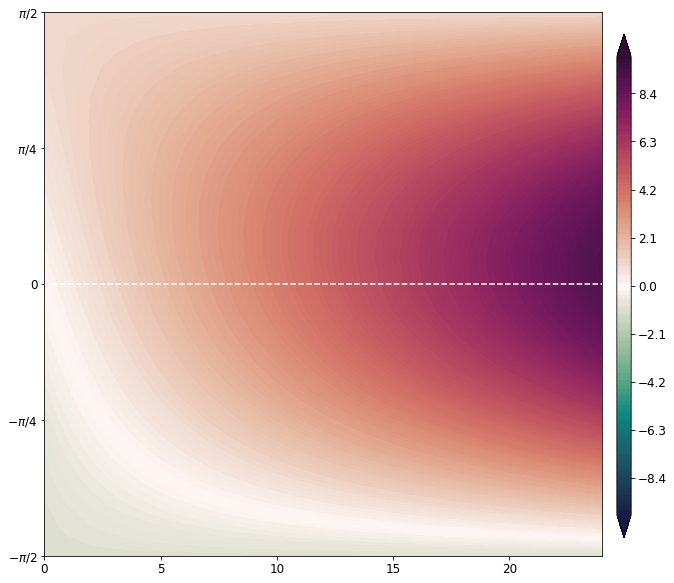

In [154]:
# Coords
hour, theta = np.meshgrid(np.arange(25), np.arange(-np.pi/2, np.pi/2+0.1, np.pi/20))
eta = calc_eta(hour, theta)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = ax.contourf(hour, theta, eta, levels=np.arange(-10, 10.1, 0.1), cmap=cm.curl, extend='both')
ax.plot([0, 24], [0, 0], 'w--')
ax.yaxis.set_ticks(np.arange(-np.pi/2, np.pi/2+0.1, np.pi/4))
ax.yaxis.set_ticklabels(['$-\pi/2$', '$-\pi/4$', 0, '$\pi/4$', '$\pi/2$'])

fig.colorbar(cbar, cax=cax)
plt.show()

The asymmetry is negligible beyond even just a few hours of sustained wind. It could still improve the scaling however (but probably not).

***